In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt

# Import the TCGA cancer data

In [2]:
folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

# luad_data.GE.drop_genes(set(luad_data.GE.get_genes_list()) & set(luad_data.LNC.get_genes_list()))

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20284)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:573: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID",how="left")
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:292: FutureWarning: 'symbol' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.HGNC_lncrna_info.groupby("symbol").first(), on="symbol",
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'Gene Name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)


Processed genes info for  LNC


# Heterogeneous Network

In [2]:
import pickle

with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network.pickle', 'rb') as file:
    network = pickle.load(file)

In [6]:
from moge.network.heterogeneous_network import HeterogeneousNetwork
# from moge.utils.omics_distance import compute_expression_correlations, compute_annotation_similarity
network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)


MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


In [7]:
# READ Edgeslist
network.import_edgelist_file(file="lncRNA-miRNA-mRNA_new-08-14.edgelist", 
                             is_directed=True)

In [8]:
network.G.number_of_edges()

4034787

In [20]:
# WRITE Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"]), 
#                   "lncRNA-miRNA-mRNA_new-08-14.edgelist", 
#                   data=True)

#### Write node labels to file

In [24]:
from moge.utils.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_labels_disease.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE"], remove_na=True, sep="\t",
#                           get_dummies=False)

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:526: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


# Add Node Similarity Edges

In [7]:
network.add_edges_from_nodes_similarity(modality="GE", similarity_threshold=0.80, dissimilarity_threshold=0.1,
                                        negative_sampling_ratio=5)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing Transcript sequence , dtype: object , shape: (20284,)
Global alignment seq score
Gower's dissimilarity: Computing location , dtype: object , shape: (20284,)
Location split to Chromosome, arm, region
          Chromosome  arm region
symbol                          
A1BG              19    q     13
A1CF              10    q     11
A2M               12    p     13
A2ML1             12    p     13
A4GALT            22    q     13
A4GNT              3    q     22
AAAS              12    q     13
AACS              12    q     24
AACSP1           NaN  NaN    NaN
AADAC              3    q     25
AADACL2            3    q     25
AADACL3            1    p     36
AADACL4            1    p     36
AADAT              4    q     33
AAED1              9    q     22
AAGAB             1

/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:142: RuntimeWarning: invalid value encountered in greater_equal
  return np.nanmean(X, axis=0)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:144: RuntimeWarning: Mean of empty slice
  def seq_global_alignment_pairwise_score(u, v, truncate=True, min_length=300):


Gower's dissimilarity: Computing Transcript length , dtype: float64 , shape: (20284,)
Euclidean distance (normalized ptp)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:131: RuntimeWarning: Mean of empty slice
  pdists_mean_reduced = agg_func(np.array(individual_variable_distances))


257346 undirected positive edges (type='u') added.
1286730 undirected negative edges (type='u_n') added.


In [8]:
network.add_edges_from_nodes_similarity(modality="MIR", similarity_threshold=0.80, dissimilarity_threshold=0.1,
                                        negative_sampling_ratio=5.0)

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Gower's dissimilarity: Computing miR family , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing Mature sequence , dtype: float64 , shape: (1870,)
Global alignment seq score


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:131: RuntimeWarning: Mean of empty slice
  pdists_mean_reduced = agg_func(np.array(individual_variable_distances))


506 undirected positive edges (type='u') added.
2530 undirected negative edges (type='u_n') added.


In [9]:
network.add_edges_from_nodes_similarity(modality="LNC", similarity_threshold=0.80, dissimilarity_threshold=0.1,
                                        negative_sampling_ratio=1.0)

Gower's dissimilarity: Computing Transcript Type , dtype: object , shape: (12725,)
Dice distance
Gower's dissimilarity: Computing Transcript sequence , dtype: object , shape: (12725,)
Global alignment seq score
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12725,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:131: RuntimeWarning: Mean of empty slice
  pdists_mean_reduced = agg_func(np.array(individual_variable_distances))


1017766 undirected positive edges (type='u') added.
1017766 undirected negative edges (type='u_n') added.


# Add Regulatory Interaction edges

In [10]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRNA_target_interaction_edgelist(), 
#                                         modalities=["MIR", "GE"],
                                        )

In [11]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(),
#                                          modalities=["GE", "GE"],
                                        )

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2907: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
# Adds miRNA-lncRNA interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                          modalities=["LNC", "MIR"]
                                        )
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"]
                                        )

# network.remove_extra_nodes() # Also makes network unmutable

In [11]:
network.G.number_of_edges()

4034787

##### Save/Load to file

In [9]:
import pickle

with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_new.pickle', 'wb') as file:
    pickle.dump(network, file)


# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [33]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

TypeError: object of type 'generator' has no len()

In [34]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

40387
29997382


In [42]:
csr_un = network.get_adjacency_matrix(edge_type="u_n", node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_type="u", node_list=network.node_list)

In [48]:
network.get_adjacency_matrix(edge_type="n", node_list=network.node_list)

<34879x34879 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

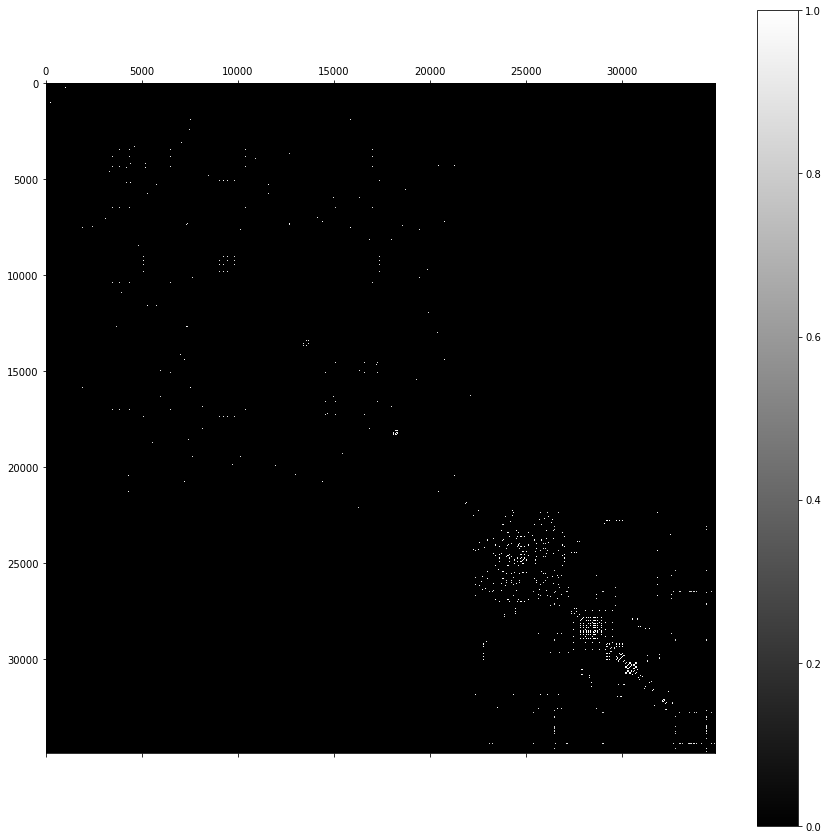

In [47]:
import matplotlib.pyplot as plt
# Scatter plot of original graph adjacency matrix
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(csr_un.toarray(), interpolation='nearest', cmap=plt.cm.gray)
fig.colorbar(cax)

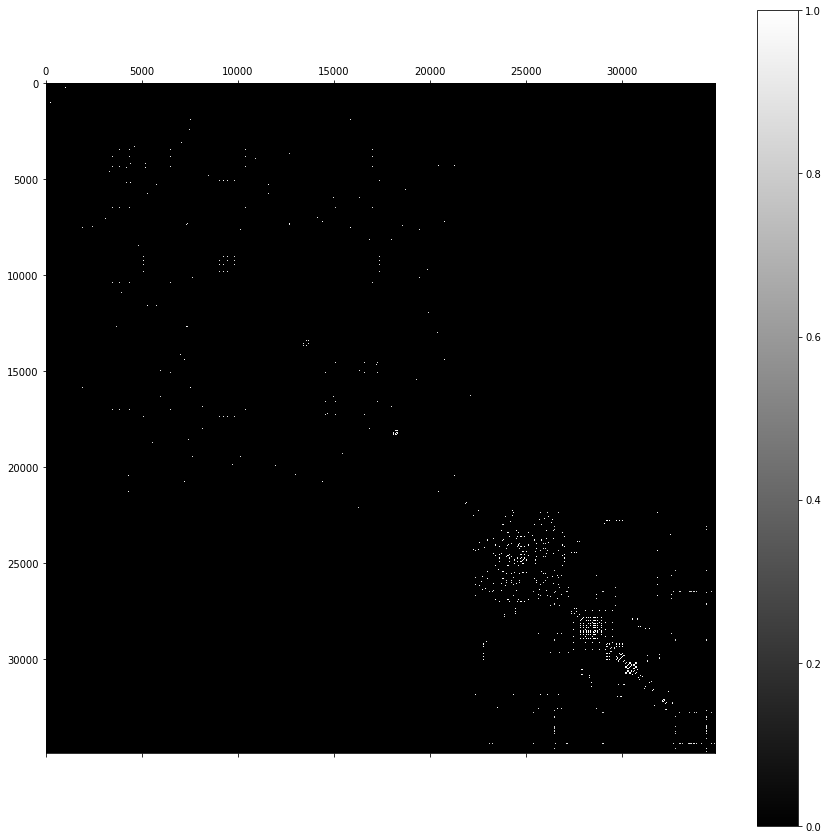

In [46]:
import matplotlib.pyplot as plt
# Scatter plot of original graph adjacency matrix
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(csr_u.toarray(), interpolation='nearest', cmap=plt.cm.gray)
fig.colorbar(cax)

# Load data_generator

In [ ]:
from moge.network.data_generator import DataGenerator
# gen = DataGenerator(network.node_list, network, )

# Laplacian Matrix

In [27]:
# G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.Graph())


/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


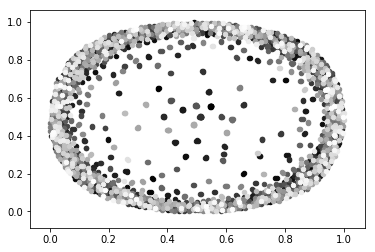

In [28]:
import community

partition = community.best_partition(network.G.to_undirected())
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
# Scatter plot of original graph adjacency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(U, interpolation='none', cmap=plt.cm.bwr)
plt.colorbar()
plt.show()

In [9]:
len([k for k, v in network.G.degree_iter() if v > 0])

20354

# Training Source Target Graph Embedding

In [4]:
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

graph_emb = SourceTargetGraphEmbedding(d=64, lr=0.1, Ed_Eu_ratio=None, epochs=5, batch_size=100000)
# graph_emb.learn_embedding(network, seed=1)


In [81]:
network.get_adjacency_matrix()[network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7c')]

0.9772727272727273

In [83]:
graph_emb.get_edge_weight(network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7e'), edge_type="u")

4.1358504e-08

In [5]:
graph_emb.import_embedding("/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_source_target_embeddings_128.embeddings",
                          node_list=network.all_nodes)

# graph_emb.save_embeddings("miRNA-mRNA_source_target_embeddings_128.embeddings")

# Import different models

In [60]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/miRNA-mRNA_LINE.txt", 
                          node_list=network.all_nodes)

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt", 
                          node_list=network.all_nodes)

node_list = list(set(line_emb.node_list) & set(node2vec_emb.node_list))

[autoreload of moge.evaluation.utils failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py", line 16, in <module>
    def split_graph_train_test(network:HeterogeneousNetwork, ):
NameError: name 'Heter

In [61]:
models = []
models.append(graph_emb)
models.append(line_emb)
models.append(node2vec_emb)

# Evaluate Source Target Graph Embeddings

In [62]:
from moge.evaluation.evaluate_graph_reconstruction import evaluateStaticGraphReconstruction

for model in models:
    print("\n",model.get_method_name())
    norm = evaluateStaticGraphReconstruction(network, model, edge_type="u", sample_ratio=1.0, 
                                             node_list=node_list)
    print(norm)


 source_target_graph_embedding
Sampling 9931984 edges to be evaluated.
0.0003173018401787234

 LINE
Sampling 9931984 edges to be evaluated.
0.00011889353738678541

 node2vec
Sampling 9931984 edges to be evaluated.
0.0012925343647035483


# Import GEM Graph Embedding Methods

In [51]:
import matplotlib.pyplot as plt
import networkx as nx

from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation.metrics import getPrecisionReport
from gem.evaluation.evaluate_link_prediction import evaluateStaticLinkPrediction

from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE
from moge.embedding.dual_graph_embedding import DualGraphEmbedding


# File that contains the edges. Format: source target
# Optionally, you can add weights as third column: source target weight

# Specify whether the edges are directed
isDirected = True

# Load graph
# G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=isDirected)
# G = G.to_directed()

# G = nx.read_edgelist('../nuclei-segmentation/notebooks/gem/data/ppi.edgelist', create_using=nx.DiGraph())
# G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.DiGraph())

G = network.G.to_directed()

G = nx.convert_node_labels_to_integers(G)

In [54]:
models = []
# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
# models.append(GraphFactorization(d=200, max_iter=100, eta=1*10**-4, regu=1.0))
models.append(LaplacianEigenmaps(d=200))
models.append(LocallyLinearEmbedding(d=200))
# models.append(node2vec(d=200, max_iter=10, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1))
# models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
#                    K=3, n_units=[50, 15,], rho=0.3, 
#                    n_iter=100, xeta=0.01, n_batch=500))

# models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

In [55]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
        embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

        Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
        MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, 
                                                                                 sample_ratio_e=0.0001, k=500000)
        print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
#         MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
#                                      train_ratio=0.8,
#                                      is_undirected=False)
#         print ("Link Prediction. MAP:", MAP)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

Num nodes: 23179, num edges: 199324

 lap_eigmap_svd lap_eigmap_svd_200
Laplacian matrix recon. error (low rank): 118.058668
lap_eigmap_svd:
	Training time: 156.647702


KeyboardInterrupt: 

# Plot Adjacency Matrix

In [8]:
def load_embeddings(filename):
    fin = open(filename, 'r')
    node_num, size = [int(x) for x in fin.readline().strip().split()]
    vectors = {} 
    while 1:
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        assert len(vec) == size+1
        vectors[vec[0]] = [float(x) for x in vec[1:]]
    fin.close()
    assert len(vectors) == node_num
    return vectors

In [9]:
mir_ge_node2vec = load_embeddings("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt")

In [14]:
mir_ge_line = load_embeddings("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_LINE.txt")

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)